In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf
tf.set_random_seed(0)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from keras import backend as K
K.set_session(sess)

from keras.layers import Input, Dense, Lambda, BatchNormalization, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras import metrics


from evaluation import *
np.random.seed(5)

Using TensorFlow backend.


In [2]:
import scipy.io
mat = scipy.io.loadmat('/home/olgako/data/datasets/thyroid.mat')

X_data = mat["X"]
#X_data = StandardScaler().fit_transform(X_data)

labels = mat["y"]

In [3]:
#X_data=MinMaxScaler().fit_transform(X_data)

In [4]:
from sklearn.model_selection import train_test_split
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, test_size=0.5, random_state = 5)

In [5]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [6]:
# enc = OneHotEncoder()
# enc.fit(labels)

In [7]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

In [8]:
scaler =  StandardScaler()
X_good = scaler.fit_transform(X_good)
X_bad = scaler.transform(X_bad)
X_test = scaler.transform(X_test)

In [9]:
X_good.shape, X_train.shape, X_data.shape

((1840, 6), (1886, 6), (3772, 6))

In [10]:
original_dim = X_good.shape[1]
latent_dim = 4

batch_size = 512
epochs = 50
epsilon_std = 1.0

dropout_rate = 0.3
start_lr = 0.001

nh1 = 16
nh2 = 8

In [11]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var/ 2 ) * epsilon

def apply_bn_and_dropout(x):
    return Dropout(dropout_rate)(BatchNormalization()(x))

In [12]:
models = {}

In [13]:
#encoder
inp = Input(shape=(original_dim,))
x = Dense(nh1)(inp)
#x = apply_bn_and_dropout(x)
x = Dense(nh2, activation='relu')(x)
#x = apply_bn_and_dropout(x)


z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)


l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


# decoder
z = Input(shape=(latent_dim, ))
x = Dense(nh2)(z)
#x = LeakyReLU()(x)
#x = apply_bn_and_dropout(x)
x = Dense(nh1, activation='relu')(x)
#x = LeakyReLU()(x)
#x = apply_bn_and_dropout(x)
decoded_mean = Dense(original_dim)(x) #, activation='sigmoid'

In [14]:
# instantiate models
models["encoder"]  = Model(inp, l, 'Encoder') 
models["z_meaner"] = Model(inp, z_mean, 'Enc_z_mean')
models["z_lvarer"] = Model(inp, z_log_var, 'Enc_z_log_var')
models["decoder"]  = Model(z, decoded_mean, name='Decoder')
models["vae"]      = Model(inp, models["decoder"](models["encoder"](inp)), name="VAE")

In [15]:
# # Compute VAE loss
def vae_loss(x, x_decoded_mean):
    sigma = 1.5
    # E[log P(X|z)]
    xent_loss = K.sum((x_decoded_mean - x) ** 2, axis=1) /2 / sigma**2
    # D_KL(Q(z|X) || P(z|X))
    kl_loss = 0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1)
    return K.mean((xent_loss + kl_loss))

In [16]:
vae = models["vae"]
vae.compile(optimizer=Adam(start_lr), loss=vae_loss)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
Encoder (Model)              (None, 4)                 320       
_________________________________________________________________
Decoder (Model)              (None, 6)                 286       
Total params: 606
Trainable params: 606
Non-trainable params: 0
_________________________________________________________________


In [17]:
size = X_good.shape
X_noise = X_good+np.random.normal(0, 1e-1, size)#*np.random.binomial(1, 0.5, size)

In [18]:
# train the VAE
history = vae.fit(X_noise, X_noise,
          shuffle=True,
          epochs=epochs,
          validation_split = 0.1,
          batch_size=batch_size)


Train on 1656 samples, validate on 184 samples
Epoch 1/50
1656/1656 [==============================] - 1s - loss: 71.6357 - val_loss: 12.1521
Epoch 2/50
1656/1656 [==============================] - 0s - loss: 44.8727 - val_loss: 9.6174
Epoch 3/50
1656/1656 [==============================] - 0s - loss: 34.5619 - val_loss: 7.9459
Epoch 4/50
1656/1656 [==============================] - 0s - loss: 21.9808 - val_loss: 7.3246
Epoch 5/50
1656/1656 [==============================] - 0s - loss: 17.0822 - val_loss: 6.1207
Epoch 6/50
1656/1656 [==============================] - 0s - loss: 14.1726 - val_loss: 5.3169
Epoch 7/50
1656/1656 [==============================] - 0s - loss: 12.3889 - val_loss: 4.8888
Epoch 8/50
1656/1656 [==============================] - 0s - loss: 10.6066 - val_loss: 4.5436
Epoch 9/50
1656/1656 [==============================] - 0s - loss: 9.4835 - val_loss: 4.1869
Epoch 10/50
1656/1656 [==============================] - 0s - loss: 9.1168 - val_loss: 3.8898
Epoch 11/50
1

In [19]:
def history_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

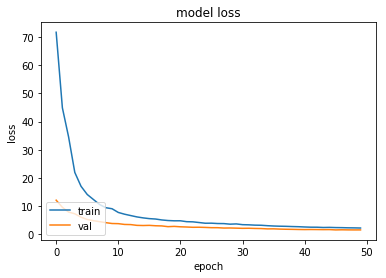

In [20]:
history_plot(history)

In [21]:
encoder= models["encoder"] 
generator = models["decoder"]

In [22]:
mean = np.zeros((latent_dim))
cov = np.eye(latent_dim)
z_samples = np.random.multivariate_normal(mean, cov, X_good.shape[0])

x_gen = generator.predict(z_samples)
x_gen_distrib = x_gen + np.random.normal(0, 1.5, x_gen.shape)

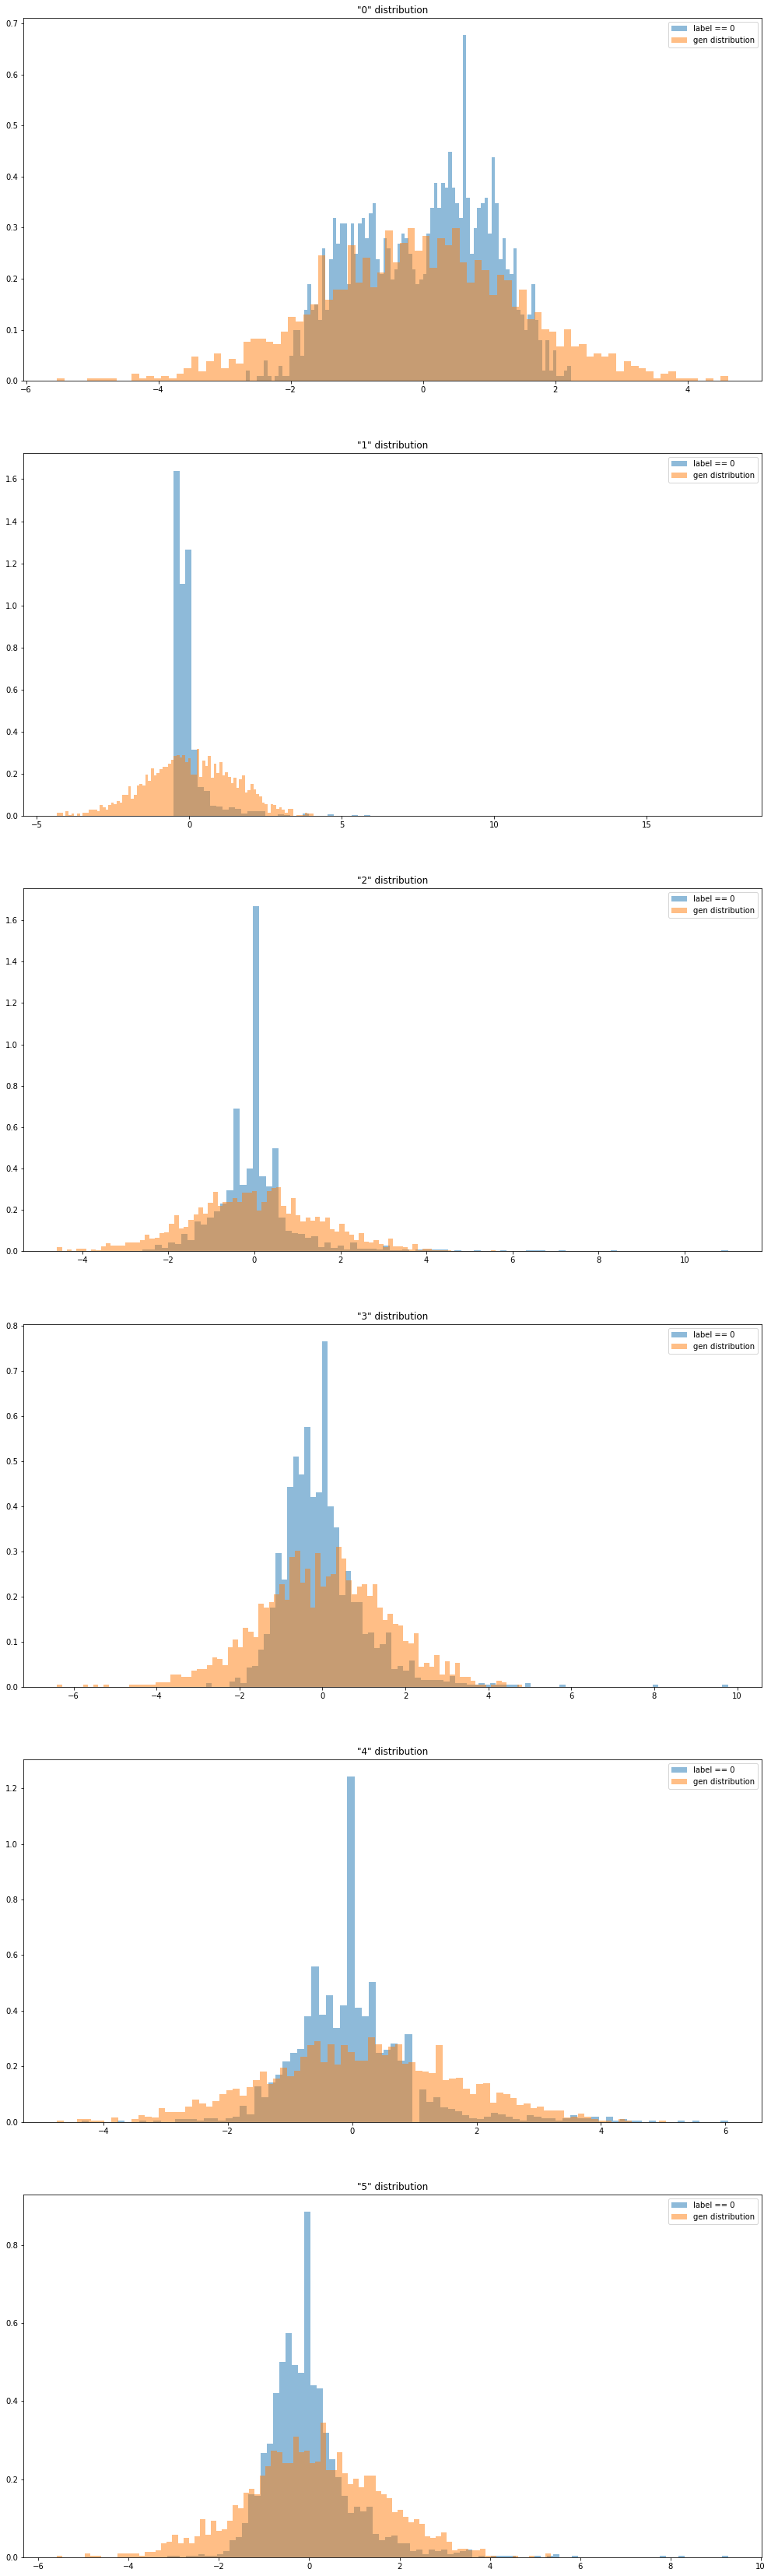

In [23]:
features_cnt = 6
plt.figure(figsize=(17,10*features_cnt))
for feature in range(features_cnt):
    plt.subplot(features_cnt,1,feature+1)
    plt.title('"%s" distribution' % feature)
    
    #plt.hist(X_noise[:,feature], label='nosy good', bins=90, alpha=0.5, normed=True)
    plt.hist(X_good[:,feature], label='label == 0', bins=90, alpha=0.5, normed=True)
    #plt.hist(X_bad[:,feature], label='label == 1', bins=90, alpha=0.5, normed=True)
    #plt.hist(x_gen[:,feature], label='generated', bins=90, alpha=0.5, normed=True)
    plt.hist(x_gen_distrib[:,feature], label='gen distribution', bins=90, alpha=0.5, normed=True)
    
    plt.legend()
plt.show()

In [24]:
z_meaner = models["z_meaner"] 
z_lvarer = models["z_lvarer"] 


def get_loss(x):
    sigma = 1.5
    x_decoded_mean=vae.predict(x)
    z_mean = z_meaner.predict(x)
    z_log_var = z_lvarer.predict(x)
    
    C = np.log(np.sqrt(2 * np.pi * sigma**2))
    # E[log P(X|z)]
    xent_loss = C + np.sum((x_decoded_mean - x) ** 2, axis=1) / 2 / sigma**2
    # D_KL(Q(z|X) || P(z|X))
    kl_loss = 0.5 * np.sum(np.exp(z_log_var) + np.square(z_mean) - 1 - z_log_var, axis=1)

    return xent_loss + kl_loss

In [25]:
def get_prob(x):
    l = np.zeros(shape=x.shape[0])
    for _ in range(100):
        l += get_loss(x)
    l /= 100
    return np.exp(-l)

P@10 0.9
recalls_values [0.8, 0.9, 0.95, 0.99]
precision_values [0.41052631578947368, 0.3282442748091603, 0.22727272727272727, 0.16785714285714284]
average_precision_score 0.65546777027
roc_auc_score 0.982107528375


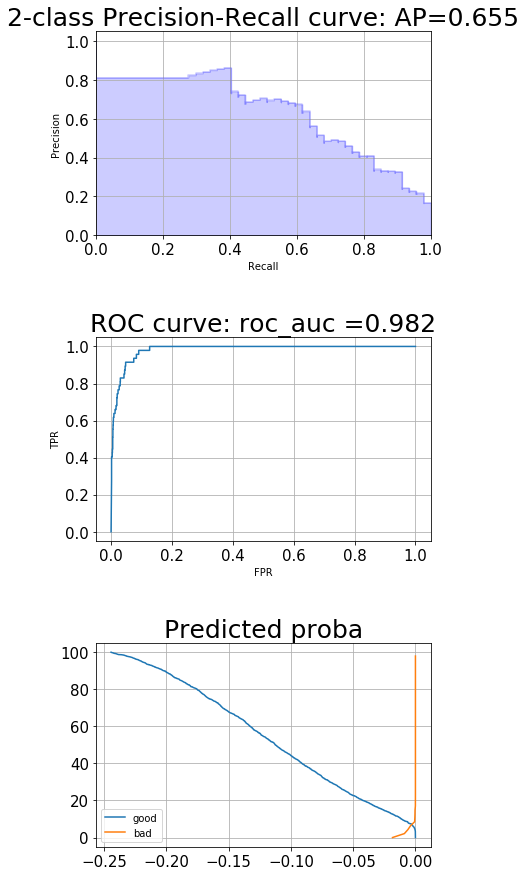

(array([ 0.16785714,  0.16487455,  0.16546763,  0.16606498,  0.16666667,
         0.16727273,  0.16788321,  0.16849817,  0.16911765,  0.1697417 ,
         0.17037037,  0.17100372,  0.17164179,  0.17228464,  0.17293233,
         0.17358491,  0.17424242,  0.17490494,  0.17557252,  0.17624521,
         0.17692308,  0.17760618,  0.17829457,  0.17898833,  0.1796875 ,
         0.18039216,  0.18110236,  0.18181818,  0.18253968,  0.18326693,
         0.184     ,  0.18473896,  0.18548387,  0.18623482,  0.18699187,
         0.1877551 ,  0.18852459,  0.18930041,  0.19008264,  0.19087137,
         0.19166667,  0.19246862,  0.19327731,  0.19409283,  0.19491525,
         0.19574468,  0.1965812 ,  0.19742489,  0.19827586,  0.1991342 ,
         0.2       ,  0.20087336,  0.20175439,  0.20264317,  0.20353982,
         0.20444444,  0.20535714,  0.20627803,  0.20720721,  0.2081448 ,
         0.20909091,  0.21004566,  0.21100917,  0.21198157,  0.21296296,
         0.21395349,  0.21495327,  0.21596244,  0.2

In [26]:
y_pred = - get_prob(X_test)
perfomance(y_test, y_pred)

In [27]:
gen_w = 1./(get_prob(x_gen_distrib) + 1e-3)

In [28]:
gen_w.shape

(1840,)

In [29]:
weights = np.ones((X_good.shape[0],1))
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)
gen_w_normed.sum(), np.sum(weights)

(1840.0, 1840.0)

In [30]:
weights_mix = np.vstack((gen_w_normed.reshape(-1,1), weights.reshape(-1,1))).reshape(-1)

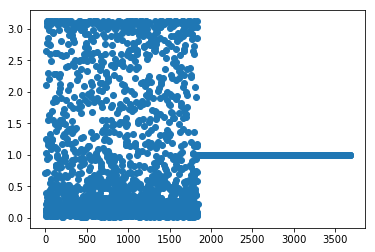

In [31]:
plt.scatter(np.arange((len(weights_mix))), weights_mix)
#plt.ylim(0,10)
plt.show()

In [32]:
X_mix = np.vstack((x_gen_distrib, X_good))

y1 = np.zeros((X_good.shape[0],1))
y2 = np.ones((x_gen.shape[0],1)) 
y_mix = np.vstack((y2, y1))

In [33]:
def build_net():
    net = Sequential()
    net.add(Dense(100, input_shape=(6,), activation = 'relu'))
    #net.add(L.BatchNormalization())
    #net.add(L.Dense(32, activation='relu'))
    net.add(BatchNormalization())
    net.add(Dropout(0.2))
    net.add(Dense(1, activation='sigmoid'))

    adam = Adam(lr=0.001)
    net.compile(optimizer=adam, loss='binary_crossentropy')
    return net

In [34]:
clf_net = build_net()

In [35]:
history = clf_net.fit(X_mix, y_mix, 
                      batch_size=512, epochs=40, validation_split = 0.1, verbose=2, shuffle=True, 
                      sample_weight=weights_mix)


Train on 3312 samples, validate on 368 samples
Epoch 1/40
0s - loss: 1.0175 - val_loss: 0.6769
Epoch 2/40
0s - loss: 0.8031 - val_loss: 0.7212
Epoch 3/40
0s - loss: 0.6251 - val_loss: 0.7502
Epoch 4/40
0s - loss: 0.5368 - val_loss: 0.7551
Epoch 5/40
0s - loss: 0.4815 - val_loss: 0.7405
Epoch 6/40
0s - loss: 0.4221 - val_loss: 0.7121
Epoch 7/40
0s - loss: 0.3784 - val_loss: 0.6796
Epoch 8/40
0s - loss: 0.3452 - val_loss: 0.6443
Epoch 9/40
0s - loss: 0.3348 - val_loss: 0.6130
Epoch 10/40
0s - loss: 0.3070 - val_loss: 0.5818
Epoch 11/40
0s - loss: 0.2950 - val_loss: 0.5612
Epoch 12/40
0s - loss: 0.2744 - val_loss: 0.5352
Epoch 13/40
0s - loss: 0.2552 - val_loss: 0.5104
Epoch 14/40
0s - loss: 0.2559 - val_loss: 0.4869
Epoch 15/40
0s - loss: 0.2339 - val_loss: 0.4626
Epoch 16/40
0s - loss: 0.2248 - val_loss: 0.4460
Epoch 17/40
0s - loss: 0.2264 - val_loss: 0.4304
Epoch 18/40
0s - loss: 0.2168 - val_loss: 0.4150
Epoch 19/40
0s - loss: 0.2153 - val_loss: 0.4001
Epoch 20/40
0s - loss: 0.2040 -

## Result with $\alpha = 0$

1376/1886 [====================>.........] - ETA: 0sP@10 0.8
recalls_values [0.8, 0.9, 0.95, 0.99]
precision_values [0.27941176470588236, 0.18803418803418803, 0.18442622950819673, 0.075320512820512817]
average_precision_score 0.587110847052
roc_auc_score 0.970890747747


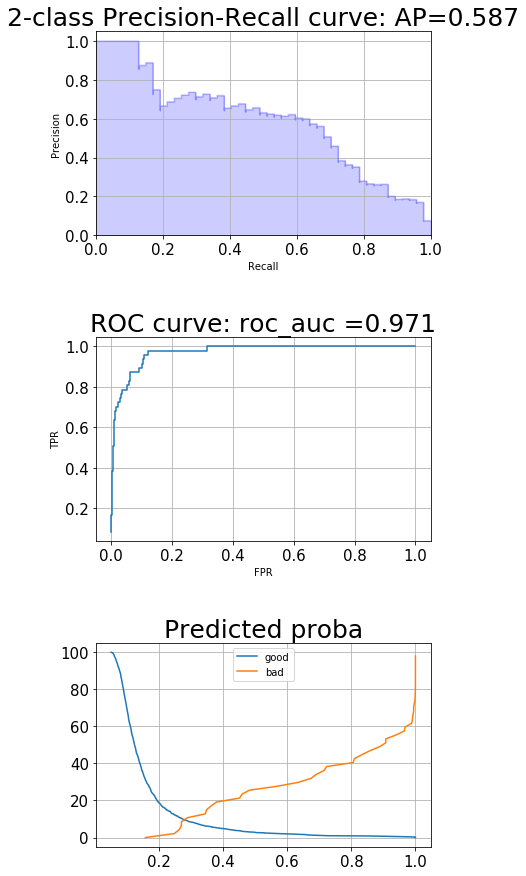

In [37]:
y_pred = clf_net.predict(X_test, verbose=1)
ps, rs = perfomance(y_test, y_pred.reshape(-1))